In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy

1. Generate an image containing a vertical edge at the middle

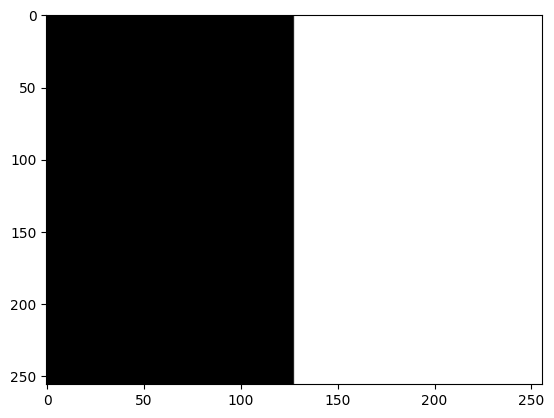

In [2]:
# Define image dimensions
width = 256
height = 256

# Create a 2D array representing the gradient
image = np.zeros((height, width))

# Populate the array with the gradient values
for i in range(width):
    if i < width/2:
        image[:, i] = 0.0
    else:
        image[:, i] = 1.0

# Plot the image
plt.imshow(image, cmap='gray', aspect='auto')
plt.show()

Text(0, 0.5, 'Pixel count')

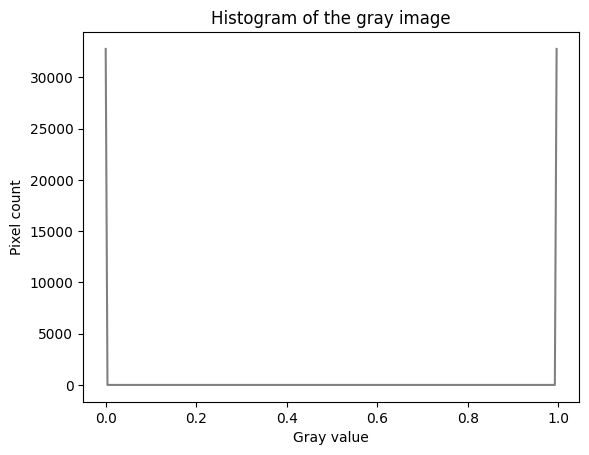

In [4]:
histogram, bin_edges = np.histogram(image[:, :], bins=256)
plt.plot(bin_edges[0:-1], histogram, color="gray")

plt.title("Histogram of the gray image")
plt.xlabel("Gray value")
plt.ylabel("Pixel count")

2. Add Gaussian White Noise

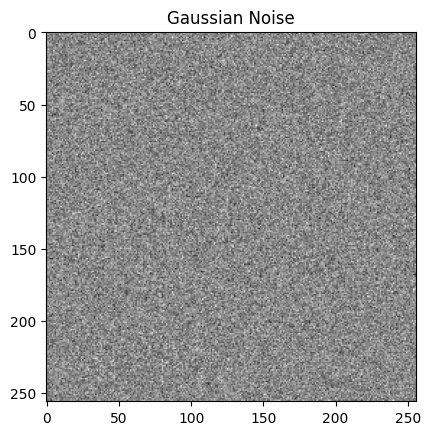

In [5]:
row, col = image.shape
noise_mean = 0
noise_std = 0.1
gauss = np.random.normal(noise_mean, noise_std, (row,col))
noise = gauss.reshape(row,col)
plt.title("Gaussian Noise")
plt.imshow(noise, cmap='gray')

Text(0, 0.5, 'Pixel count')

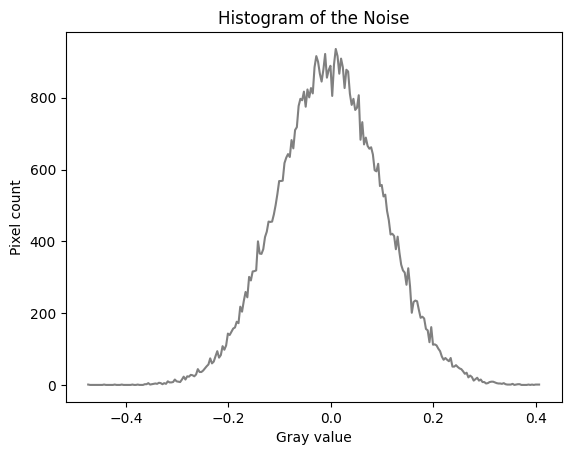

In [6]:
histogram, bin_edges = np.histogram(noise[:, :], bins=256)
plt.plot(bin_edges[0:-1], histogram, color="gray")
plt.title("Histogram of the Noise")
plt.xlabel("Gray value")
plt.ylabel("Pixel count")

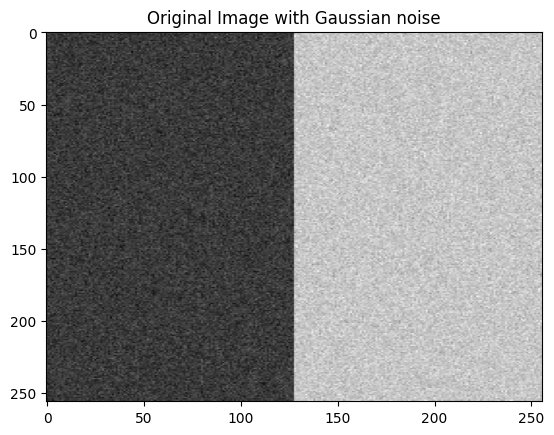

In [7]:
noisy_image = image + noise
plt.title("Original Image with Gaussian noise")
plt.imshow(noisy_image, cmap='gray', aspect = 'auto')

Text(0, 0.5, 'Pixel count')

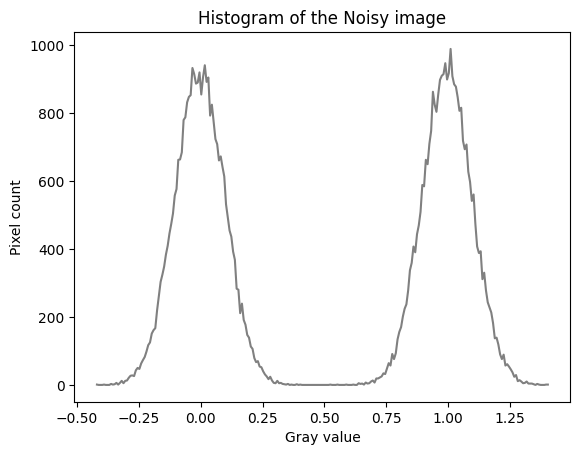

In [8]:
histogram, bin_edges = np.histogram(noisy_image[:, :], bins=256)
plt.plot(bin_edges[0:-1], histogram, color="gray")
plt.title("Histogram of the Noisy image")
plt.xlabel("Gray value")
plt.ylabel("Pixel count")

In [9]:
range_noisy = np.max(noisy_image) - np.min(noisy_image)

# Calculating SNR
snr = range_noisy / noise_std
print("snr:",snr)

# Calculating SNRdB
snr_dB = 20 * np.log10(snr)
print("snr_dB:",snr_dB)

print(np.std(noisy_image))

snr: 18.28220414854383
snr_dB: 25.240571083802372
0.510057240678905


Putting up the filters

In [10]:
filter_1d_X = [[1,-1]]
filter_1d_Y = [[1], [-1]]

Prewitt_X = [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]
Prewitt_Y = [[-1, -1, -1], [0, 0, 0], [1, 1, 1]]

Scharr_X = [[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]
Scharr_Y = [[3, 10, 3], [0, 0, 0], [-3, -10, -3]]

Sobel_X = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
Sobel_Y = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

filters = [
    {"key": "filter_1d_X", "value": filter_1d_X},
    {"key": "filter_1d_Y", "value": filter_1d_Y},
    {"key": "Prewitt_X", "value": Prewitt_X},
    {"key": "Prewitt_Y", "value": Prewitt_Y},
    {"key": "Scharr_X", "value": Scharr_X},
    {"key": "Scharr_Y", "value": Scharr_Y},
    {"key": "Sobel_X", "value": Sobel_X},
    {"key": "Sobel_Y", "value": Sobel_Y}
]

filters_list = ['Kernel 1d', 'Prewitt', 'Scharr', 'Sobel']

subplot_rows, subplot_columns = len(filters_list), 2


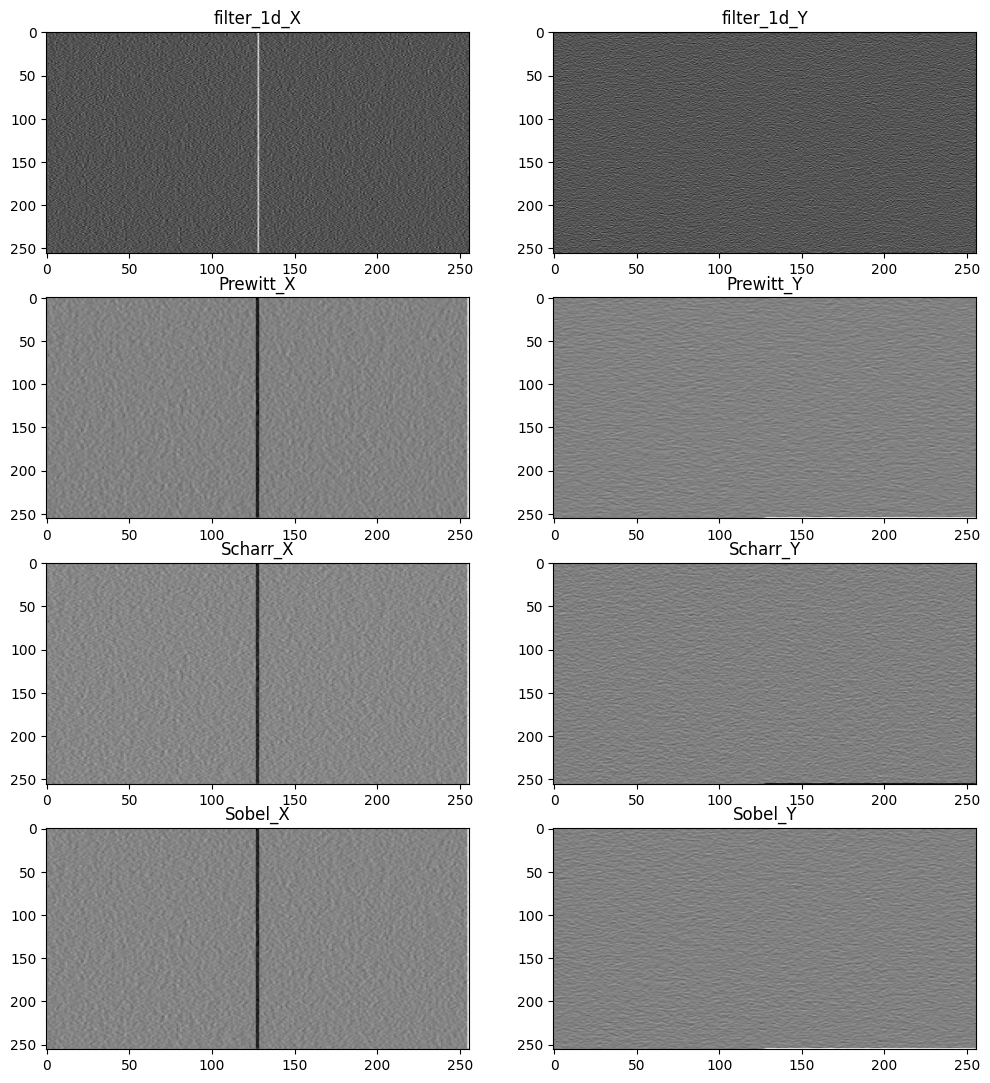

In [ ]:
# Passing noisy image into each filters
plt.figure(figsize = (12,subplot_rows * 2 * 3 + 3))
d_x_y = []

for i in range(len(filters)):
    
    plt.subplot(subplot_rows * 2, subplot_columns, i+1)
    res = scipy.signal.convolve2d(noisy_image, filters[i]["value"],
                                  mode='same', boundary='fill', fillvalue=0)
    d_x_y.append(res)
    plt.title(filters[i]["key"])
    plt.imshow(res, cmap='gray', aspect = 'auto')

[0] [1]
[2] [3]
[4] [5]
[6] [7]


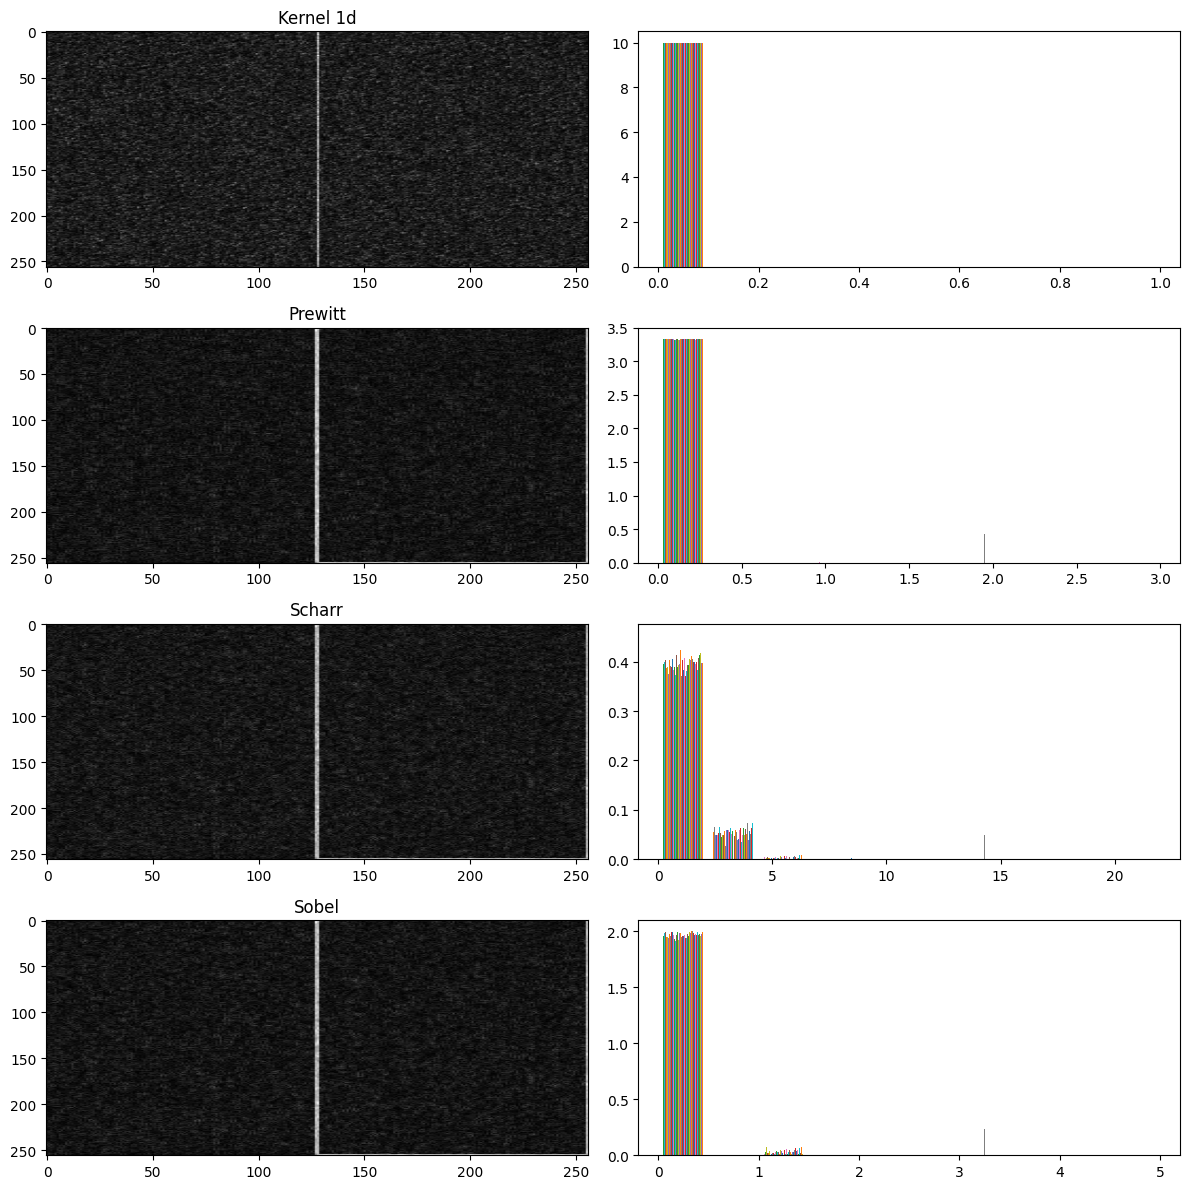

In [12]:
def non_max_suppression(G, theta):
    M, N = G.shape
    Z = np.zeros((M,N), dtype=np.int32) # resultant image
    angle = theta * 180. / np.pi        # max -> 180, min -> -180
    angle[angle < 0] += 180             # max -> 180, min -> 0

    for i in range(1,M-1):
        for j in range(1,N-1):
            q = r = 255
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                r, q = G[i, j-1], G[i, j+1]
            elif (22.5 <= angle[i,j] < 67.5):
                r, q = G[i-1, j+1], G[i+1, j-1]
            elif (67.5 <= angle[i,j] < 112.5):
                r, q = G[i-1, j], G[i+1, j]
            elif (112.5 <= angle[i,j] < 157.5):
                r, q = G[i+1, j+1], G[i-1, j-1]
                
            Z[i,j] = G[i,j] if (G[i,j] >= q) and (G[i,j] >= r) else 0
    
    return Z

plt.figure(figsize = (12,subplot_rows * 3))

ldirs = []
for i in range(int(len(d_x_y)/2)): 
    print([i*2], [i*2 + 1])
    mag = np.sqrt((d_x_y[i*2]**2) + (d_x_y[i*2 + 1]**2))
    t = non_max_suppression(mag, np.arctan2(d_x_y[i*2 + 1], d_x_y[i*2]))
    plt.subplot(subplot_rows, subplot_columns, i*2+1)
    plt.title(filters_list[i])
    plt.imshow(mag, cmap='gray', aspect = 'auto')
    ldirs.append(t)
    
    plt.subplot(subplot_rows, subplot_columns, i*2+2)
    plt.hist(t, density=True, bins=10)
    
plt.tight_layout()
plt.show()

In [17]:
ldirs = np.array(ldirs)

# plt.figure(figsize = (10,50))

total_distributions = 104
F_values = [[] for i in range(subplot_rows)]
SNR_values = [[] for i in range(subplot_rows)]


distributions = np.round(np.linspace(0, 20, num = total_distributions), 2)
for j, gap in enumerate(distributions):
    print("Threshold", gap)
    for i in range(len(ldirs)):
        threshold_array = np.where(ldirs[i] > gap, 1, 0)
        nd = 0
        s = 0.0
        for m in range(threshold_array.shape[0]):
            for n in range(threshold_array.shape[1]):
                if threshold_array[m, n] == 1:  # If a pixel is 255, meaning it is an edge
                    s += 1 / (1 + 0.9 * (n - 128) ** 2)  # Calculate formula for PFOM
                    nd += 1  # Count number of edges

        F = 100 / max(253, nd) * s
        F_values[i].append(F)
        # print(F)
        
        # Calculating SNR
        range_noisy = np.max(threshold_array) - np.min(threshold_array)
        snr = range_noisy / np.std(threshold_array)
        snr_dB = 20 * np.log10(snr)
        SNR_values[i].append(snr_dB)

    print()

Threshold 0.0

Threshold 0.19

Threshold 0.39

Threshold 0.58

Threshold 0.78

Threshold 0.97

Threshold 1.17

Threshold 1.36


/var/folders/pl/cdtxfpj90yv22wr7bnk7kyxh0000gn/T/ipykernel_1487/469006641.py:29: RuntimeWarning: invalid value encountered in scalar divide
  snr = range_noisy / np.std(threshold_array)



Threshold 1.55

Threshold 1.75

Threshold 1.94

Threshold 2.14

Threshold 2.33

Threshold 2.52

Threshold 2.72

Threshold 2.91

Threshold 3.11

Threshold 3.3

Threshold 3.5

Threshold 3.69

Threshold 3.88

Threshold 4.08

Threshold 4.27

Threshold 4.47

Threshold 4.66

Threshold 4.85

Threshold 5.05

Threshold 5.24

Threshold 5.44

Threshold 5.63

Threshold 5.83

Threshold 6.02

Threshold 6.21

Threshold 6.41

Threshold 6.6

Threshold 6.8

Threshold 6.99

Threshold 7.18

Threshold 7.38

Threshold 7.57

Threshold 7.77

Threshold 7.96

Threshold 8.16

Threshold 8.35

Threshold 8.54

Threshold 8.74

Threshold 8.93

Threshold 9.13

Threshold 9.32

Threshold 9.51

Threshold 9.71

Threshold 9.9

Threshold 10.1

Threshold 10.29

Threshold 10.49

Threshold 10.68

Threshold 10.87

Threshold 11.07

Threshold 11.26

Threshold 11.46

Threshold 11.65

Threshold 11.84

Threshold 12.04

Threshold 12.23

Threshold 12.43

Threshold 12.62

Threshold 12.82

Threshold 13.01

Threshold 13.2

Threshold 13.

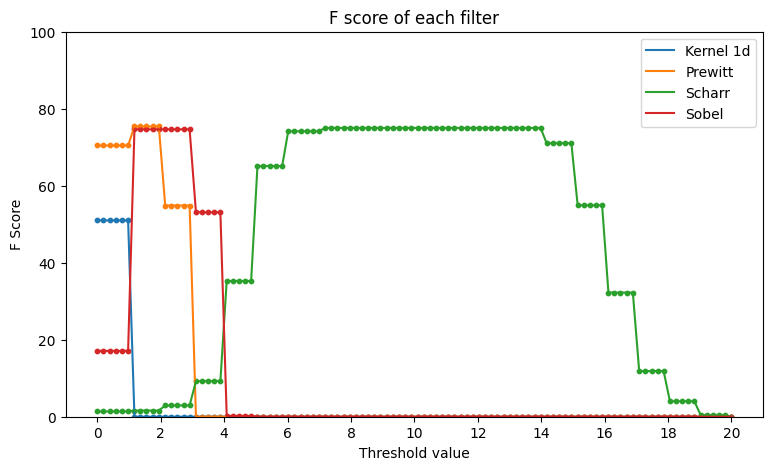

In [27]:

plt.figure(figsize=(9,5))
plt.ylim(0,100)

for i in range(subplot_rows):
    plt.plot(distributions, F_values[i], label = filters_list[i])
    plt.scatter(distributions, F_values[i], s = 10)
plt.title("F score of each filter")
plt.xlabel("Threshold value")
plt.ylabel("F Score")
plt.legend(loc='best')
plt.xticks(np.round(np.linspace(0, 20, num = 11), 1))
plt.show()

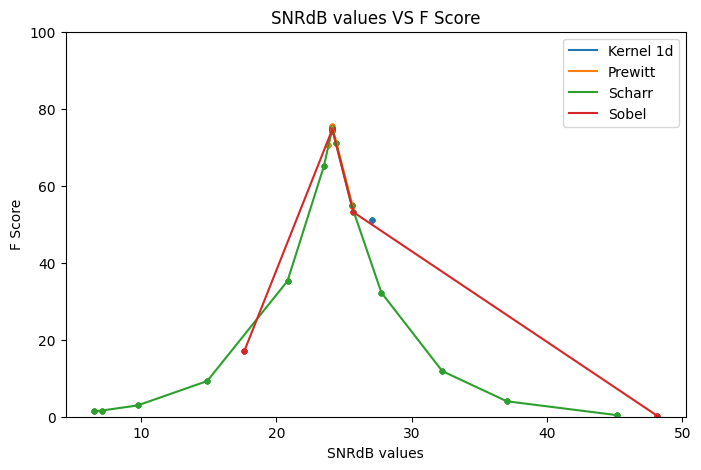

In [28]:

plt.figure(figsize=(8,5))
plt.ylim(0,100)

for i in range(subplot_rows):
    plt.plot(SNR_values[i], F_values[i],  label = filters_list[i])
    plt.scatter(SNR_values[i], F_values[i], s = 10)
    
plt.title("SNRdB values VS F Score")
plt.xlabel("SNRdB values")
plt.ylabel("F Score")
plt.legend(loc='best')
# plt.xticks(np.round(np.linspace(0, 20, num = 11), 1))
plt.show()